# **데이터 불러오기**

In [1]:
import os
os.chdir('/Users/minguinho/Downloads/헬스 데이터/open')

In [2]:
import pandas as pd
import numpy as np

train_features=pd.read_csv('/Users/minguinho/Downloads/헬스 데이터/open/train_features.csv')
train_labels=pd.read_csv('/Users/minguinho/Downloads/헬스 데이터/open/train_labels.csv')
test=pd.read_csv('/Users/minguinho/Downloads/헬스 데이터/open/test_features.csv')
submission=pd.read_csv('/Users/minguinho/Downloads/헬스 데이터/open/sample_submission.csv')

# **라이브러리 불러오기**

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# **데이터 수정**

In [4]:
# mlcompute.set_mlc_device(device_name='gpu')

x_train = []

for uid in tqdm(train_features['id'].unique()):
    temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train = x_train[:,:,:,np.newaxis]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:,np.newaxis]

100%|██████████| 782/782 [00:00<00:00, 1179.10it/s]


In [5]:
shift_data = np.roll(x_train, int(random.random()*600), axis=2)
shift_data =  shift_data.reshape((-1, 600, 6))
x_test =  x_test.reshape((-1, 600, 6))
y = tf.keras.utils.to_categorical(train_labels['label']) 

# **모델 학습 및 예측**

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCH = 300
BATCH_SIZE = 256

filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 5*1e-8 * 10**(epoch / 20))

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=(600, 6)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(61, activation='softmax'))


optimizer = tf.keras.optimizers.RMSprop(lr = 1e-4)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 600, 32)           992       
_________________________________________________________________
dropout_6 (Dropout)          (None, 600, 32)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 600, 128)          49664     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 600, 128)          98816     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [13]:
history = model.fit(shift_data, y, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint])

[==============================] - 35s 4s/step - loss: 0.7344 - accuracy: 0.7905 - val_loss: 0.9808 - val_accuracy: 0.7296

Epoch 00201: val_loss did not improve from 0.93377
Epoch 202/300
10/10 [==============================] - 34s 3s/step - loss: 0.7107 - accuracy: 0.7906 - val_loss: 0.9133 - val_accuracy: 0.7584

Epoch 00202: val_loss improved from 0.93377 to 0.91332, saving model to checkpoint-epoch-300-batch-256-trial-001.h5
Epoch 203/300
10/10 [==============================] - 35s 4s/step - loss: 0.6940 - accuracy: 0.8000 - val_loss: 0.9130 - val_accuracy: 0.7632

Epoch 00203: val_loss improved from 0.91332 to 0.91297, saving model to checkpoint-epoch-300-batch-256-trial-001.h5
Epoch 204/300
10/10 [==============================] - 35s 4s/step - loss: 0.7265 - accuracy: 0.7950 - val_loss: 0.9923 - val_accuracy: 0.7424

Epoch 00204: val_loss did not improve from 0.91297
Epoch 205/300
10/10 [==============================] - 35s 4s/step - loss: 0.7506 - accuracy: 0.7815 - val_los

(1e-08, 0.1, 0.0, 10.0)

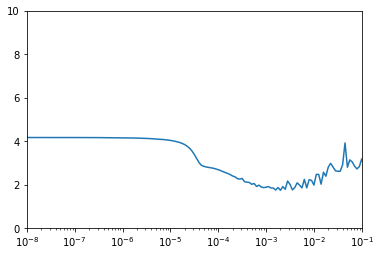

In [127]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 10])

In [122]:
for i in range(0, len(history.history["lr"])) :
    print("lr : " )
    print(history.history["lr"][i] )
    print("loss : ")
    print(history.history["loss"][i])

lr : 
1e-08
loss : 
4.161421298980713
lr : 
1.1220185e-08
loss : 
4.161536693572998
lr : 
1.2589254e-08
loss : 
4.158461093902588
lr : 
1.41253755e-08
loss : 
4.160787105560303
lr : 
1.5848931e-08
loss : 
4.160204887390137
lr : 
1.7782794e-08
loss : 
4.159872055053711
lr : 
1.9952623e-08
loss : 
4.160655975341797
lr : 
2.2387212e-08
loss : 
4.160436630249023
lr : 
2.5118863e-08
loss : 
4.159906387329102
lr : 
2.8183829e-08
loss : 
4.16263484954834
lr : 
3.1622776e-08
loss : 
4.1595635414123535
lr : 
3.548134e-08
loss : 
4.16099214553833
lr : 
3.981072e-08
loss : 
4.161916732788086
lr : 
4.4668358e-08
loss : 
4.160027980804443
lr : 
5.011872e-08
loss : 
4.16102933883667
lr : 
5.6234132e-08
loss : 
4.160132884979248
lr : 
6.309573e-08
loss : 
4.160602569580078
lr : 
7.079458e-08
loss : 
4.161985397338867
lr : 
7.943282e-08
loss : 
4.159969329833984
lr : 
8.9125095e-08
loss : 
4.159895420074463
lr : 
1e-07
loss : 
4.159889221191406
lr : 
1.12201846e-07
loss : 
4.15972375869751
lr : 
1.258

In [14]:
model.load_weights(filename)

In [15]:
prediction=model.predict(x_test)
prediction.shape

(782, 61)

In [43]:
prediction_test=model.predict(shift_data)

In [44]:
logs=tf.compat.v1.losses.log_loss(y ,prediction_test)


# **제출**

In [16]:
submission # 대입 전

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
submission.iloc[:,1:]=prediction
submission # 대입 후

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000240,1.347092e-04,1.766771e-06,0.000029,1.614321e-01,4.424791e-06,3.463458e-05,1.740017e-05,7.430706e-05,...,1.585404e-03,4.493349e-04,3.980137e-04,2.548228e-05,1.327194e-05,4.506620e-07,0.000098,1.305984e-01,4.865029e-06,1.005985e-04
1,3126,0.000129,4.424005e-07,2.046113e-08,0.000559,8.257740e-07,2.343526e-06,9.093794e-07,4.240705e-06,1.462471e-06,...,8.273541e-06,3.761283e-08,4.707277e-07,6.980721e-06,5.926229e-08,4.932133e-08,0.005953,6.026338e-06,2.818183e-08,4.048059e-05
2,3127,0.010152,1.371774e-02,2.047465e-07,0.000724,1.714435e-05,6.260178e-05,6.094365e-04,1.353542e-03,4.835736e-04,...,1.069753e-05,1.665910e-06,1.469030e-07,7.643314e-03,6.167265e-06,2.040667e-05,0.000081,2.405031e-05,9.255677e-05,7.752351e-04
3,3128,0.001142,2.032860e-06,4.042127e-08,0.000060,3.797761e-05,4.333036e-05,2.510854e-07,1.787993e-04,1.080438e-05,...,1.080930e-06,3.113977e-07,3.890761e-08,3.991811e-05,8.831680e-08,8.327959e-07,0.000618,8.299892e-07,3.861038e-07,1.540657e-03
4,3129,0.002217,7.798604e-06,1.095230e-07,0.000317,2.140477e-03,5.112460e-06,7.500231e-06,7.826978e-06,5.242071e-06,...,3.427697e-05,3.117480e-06,2.228643e-06,5.489841e-06,3.302522e-07,3.325589e-08,0.008965,4.680156e-04,1.062259e-06,1.098181e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000084,2.174810e-06,3.777786e-09,0.000034,3.169900e-05,1.474271e-07,1.886434e-06,1.778025e-06,8.808286e-07,...,6.847079e-06,7.201080e-07,8.960312e-08,5.832458e-07,6.194855e-09,1.145300e-08,0.021687,2.081725e-04,1.401035e-07,1.192118e-04
778,3903,0.000074,7.207404e-08,7.282483e-11,0.000013,5.237309e-07,1.324320e-07,7.812767e-08,1.626469e-07,2.511593e-06,...,2.542834e-07,3.860804e-08,3.120717e-09,3.661049e-07,5.766242e-10,4.130424e-09,0.000519,9.922036e-07,7.164446e-09,1.043399e-04
779,3904,0.000392,4.934305e-07,1.399620e-08,0.000030,4.194517e-05,3.643509e-05,3.649031e-07,1.656478e-05,6.876101e-06,...,1.308245e-05,8.600182e-07,1.652475e-07,9.081095e-06,2.423693e-07,6.447446e-07,0.003164,3.681565e-06,4.387419e-07,9.811115e-04
780,3905,0.000089,1.051910e-02,4.221992e-07,0.000024,1.200896e-06,1.047734e-07,1.945160e-02,3.255530e-04,2.622788e-06,...,5.113100e-07,2.021090e-08,1.532742e-08,1.385386e-04,7.148197e-07,1.074453e-06,0.000039,1.431577e-05,1.549162e-04,6.859416e-07


In [18]:
submission.to_csv('baseline_submission.csv', index=False)